# Unbiased Offline Estimates of Online Metrics
### Author: aarshay jain

# Introduction / Motivation

If my offline model has a better AUC than the production, is it necessarily better for the business? Does a higher AUC, imply improvement in business metrics? How much improvement in AUC is good enough to attemp to deploy a new model and run an A/B test?

These are some of the common questions which torment ML practitioners in there daily jobs, specially when building user facing ML products. Some common scenarios behind these concerns are:
- ML applications are trying to drive a product which is judged by business metrics like click rates, revenue, engagement, etc. These are dependent on user feedback/interaction in some form which is hard to estimate offline.
- ML models are typically deployed along with some business heuristics which control how the model output translates to product action like which song to play or which ad to show.
- Many applications chain predictions from multiple models to take an action. For example, the decision of which ad to show could depend on ML models for click rate predictions and demand forecasts along with business constraints like inventory and user eligibility.

In such scenarios, typical ML metrics like accuracy, auc-roc, precision-recall etc for individual models are generally not enough to tell whether an offline model is better than the model in production. A/B tests are typically used to do such evaluation but the are expensive to run both in terms of cost and time. Counterfactual Evaluation provides a methodology of using production logs to estimate the online metrics like click rate, revenue, etc. These could act as a first filter on offline models to help decide which ones to test in product using an A/B test.

# Advertising Example

Counterfactual evaluation techniques are inspired from causal inference literature. Lets take an example from advertising world to understand this better. Consider 2 sides of the scenario:
- User side - user visits a website and receives an ad; if the user likes the ad, they clicks on the ad otherwise not
- Business side - an ML system receives a request with current user context and picks an ad

This system can be defined using the following variables:
- u: user-intent
    A user visits the website with some intent. Eg, user visits amazon.com to buy a shoe
- x: user-context
    User starts browsing on the website and their activity is packaged as a context vector
- v: inventory
    Inventory of all ads available to show
- b: bids
    A system which bids a price per click for ads from the ad inventory
- a: selected_ad
    A final ad will be selected based on the bids and click estimates
- y: click
    Binary 1 if user clicks on ad and 0 otherwise
- z:
    Some revenue generated from the interaction
    
Note: This example is a sligtly toned down version of the example used in ???. The entire explanation here is a brief summary from the same resource

## Goal

In this system, lets say click rate is the business metric we're trying to maximize. Click rate is defined as the proportion of advertisements clicked by users, across user sessions. Suppose we have a production system running and now we develop a new model for selecting an ad, i.e. we have a new way of implementing variable `a`. We want to estimate the click rate of this model as compared to the production model. 

## Causal Graph
To answer the question, lets start with creating a causal graph for the system:

-- fig1: causal graph --

From this graph, we can observe:
- u,v are independent variables, also known as exogenous variables
- x = f(u)
- b = f(x,v)
- a = f(x,b)
- y = f(a,u)
- z = f(y,b)

Using these equations and graph, we can represent the join probability of the entire system as a probabilistic generative model as:

$$P(w) = P(u,v).P(x|u).P(b|x,v).P(a|x,b).P(y|u,a).P(z|y)$$
where w is the set of all variables.

## Isolation Assumption

Before moving forward, lets understand one of the core assumptions in this model. Like any causal graph, this graph assumes that the exogenous variables don't have any back door path into the netwrok, i.e. there are no common cause between the exogenous variables (u,v) and other variables in the network. For example: 

--figure2

In this figure, the causal path represented in red are back door paths which invalidate the previously defined system of equations. Another way of stating this assumption is that saying we assume all observations of exogenous variables are independentally sampled from an unknown but fixed joint distribution. This is the isolation assumption. Most causal grahs make this assumption and we might be able to argue practical back door paths which are not accounted for because such causes cannot be measured/modeled. But it is important to be aware that this assumption is being made.

## Modeling Interventions 

This system of equations allows us to model interventions as algebraic manipulations i.e. we can change some interim distributions and model a different output for a given input. Refer to Pearl's do-calculus for more details. 


# Counterfactual Analysis

## What is Counterfactual?

The question "what would happen if we replace a current model M with a new model M'" is counterfactual in the sense that we are not actually making the change and impacting user experience. We are just trying to estimate business metrics in the scenario when we would actually deploy the model M'. 

## Analogy to traditional ML

While training models in a supervised learning setting, we use some independent variables x and true labels y then we try to estimate y as y' = f(x). y' is kind of a counterfactual estimate of what would happend if instead of the system generating the data the model f(x) was used. Then we define a loss function and optimize the model. All this works because f(x) is fully defined which is not the case in our problem i.e. there is no way to know how a user would have interacted if a different ad would shown. 

# Markov Factor Replacement

Now lets try to perform algebraic manipulations in our system of equation. Say we have a new model M' for selection of an ad gived bids. This will impact just one component of the equation:

$$P(a|x,b) -> P'(a|x,b)$$

The click rate of the system can be defined as:



# Simulation 

Let's try to understand this using a similuated example, similar to the one we've been working with:
- We have 3 ads in inventory, valid for all user contexts
- We simulate N number of user contexts, each with a different click probability on one of the ads
- We collect some online data by serving ads randomly to users in different contexts and observing click behavior. Random serving is a good way to collect unbiased online data to evaluate online models and should be adopted when possible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

## 1. Data Preparation

### User Contexts
Lets start by defining some 10K user context ids and define a probability distribution on their occurence, i.e. sum contexts are more likely to repeat than others

In [2]:
# set user contexts
num_contexts = 10000
user_contexts = np.asarray(["context_{}".format(i) for i in range(num_contexts)])

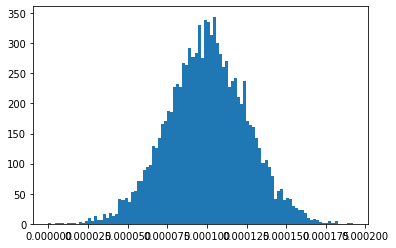

In [12]:
# assign selection prior to these contexts
def random_normal_sample_sum_to_1(size):
    sample = np.random.normal(0, 1, size)
    sample_adjusted = sample - sample.min()
    return sample_adjusted / sample_adjusted.sum()
user_context_selection_prior = random_normal_sample_sum_to_1(num_contexts)
plt.hist(user_context_selection_prior, bins=100)
assert user_context_selection_prior.sum().round(2) == 1.0

### Click Rate Per Context
Lets define 3 ads in our inventory. For sake of simplicity, lets say the click rate for a given ad in a given context can be one of:
- Low: 10%
- Medium: 40%
- High: 60%

Then we can randomly assign which of the ads is low/med/high in which context

In [13]:
# set ads
num_ads = 3
ads = np.asarray(["ad_{}".format(i) for i in range(num_ads)])

In [37]:
# assign random priors to contexts
ad_interaction_priors = np.asarray([0.1, 0.3, 0.6])
user_context_priors = {context:np.random.permutation(ad_interaction_priors) for context in user_contexts}

## 2. Random Data Collection
Now we'll simulate 100K iterations where one of the 10K user contexts is given as input to the model, a random ad is served and based on the click prior for that ad in that context, an action of click or no click is sampled.

In [16]:
from uuid import uuid4

In [15]:
num_iterations = 100000

In [17]:
# create empty df for storing logs
df_random_serving = pd.DataFrame(
    columns = ["id", "context_id", "selected_ad", "user_interaction"]
)

# create unique ID for each log entry
df_random_serving["id"] = [uuid4() for _ in range(num_iterations)]

# assign a context id to each log entry
df_random_serving["context_id"] = np.random.choice(user_contexts, size=num_iterations, replace=True, p=user_context_selection_prior)

# randomly sample an ad to show in that context
df_random_serving["selected_ad"] = np.random.choice(ads, size=num_iterations, replace=True)

In [38]:
# for each log entry, sample an action or click or not using the click probability assigned to the context-ad pair in step 1
def sample_action_for_ad(context_id, ad_id):
    prior = user_context_priors.get(context_id)[np.where(ads == ad_id)[0][0]]
    return np.random.binomial(1, prior)
df_random_serving["user_interaction"] = df_random_serving.apply(lambda x: sample_action_for_ad(x["context_id"], x["selected_ad"]), axis=1)

In [39]:
# a snapshot of the data
df_random_serving.sample(20)

,id,context_id,selected_ad,user_interaction
94702,590effe4-d2da-462f-b143-ec0fe71a7449,context_3006,ad_2,1
30702,6ab87741-1137-4f64-b69a-9662b436456a,context_9416,ad_2,0
39806,14a208ba-c51b-4b21-aa44-f95d96f72082,context_5532,ad_1,0
84175,cd945827-8cdc-4f11-b5aa-74dcab163588,context_6631,ad_0,1
39037,7688990e-7661-405d-8ace-b20a5e4776d3,context_8070,ad_1,0
30926,4534ebb6-6626-42b1-bdd9-ea6f5bd7ac7f,context_5771,ad_1,0
57728,4adce01b-7e44-420e-9444-c5e70d61ecc9,context_7188,ad_2,0
93241,eb2d37b3-12fe-4788-9fac-4ba9e9060f1b,context_1407,ad_1,1
96326,3a035b70-dcc9-48d4-943d-e3d73312ed96,context_9935,ad_1,0
7053,fc022b4e-a180-4a70-9fb4-b6f6701b4e7d,context_8301,ad_2,1


We will use this as our logged data and test new models against this

## 3. New Model estimation

### Define models

Now lets define some models for which we can establish an intuition of order of performance on click rate. One way to do so is to set priors on the likelihood of picking the low/med/high ad using a vector \[p_low, p_med, p_high\] for a given context. We can intuitively say that the models with a higher likelihood of picking more performant ads for a context will work better. Note that this is not how an actual model would work. But here we're trying to simulate the output of different models.

Here's a group of 10 models with increasing expected performance:

In [23]:
new_policy_priors = np.atleast_2d([
    [0.8, 0.1, 0.1],
    [0.7, 0.2, 0.1],
    [0.6, 0.2, 0.2],
    [0.5, 0.3, 0.2],
    [0.5, 0.2, 0.3],
    [0.4, 0.3, 0.3],
    [0.4, 0.2, 0.4],
    [0.3, 0.3, 0.4],
    [0.2, 0.35, 0.45],
    [0.2, 0.2, 0.6]
])

For clarification, lets see this as a dataframe:

In [23]:
new_policy_names = np.asarray(["model_{}".format(i) for i in range(new_policy_priors.shape[0])])
pd.DataFrame(
    data=np.hstack([np.atleast_2d(new_policy_names).T, new_policy_priors]),
    columns=["policy_id", "prob_low", "prob_med", "prob_high"]
)

,policy_id,prob_low,prob_med,prob_high
0,policy_0,0.8,0.1,0.1
1,policy_1,0.7,0.2,0.1
2,policy_2,0.6,0.2,0.2
3,policy_3,0.5,0.3,0.2
4,policy_4,0.5,0.2,0.3
5,policy_5,0.4,0.3,0.3
6,policy_6,0.4,0.2,0.4
7,policy_7,0.3,0.3,0.4
8,policy_8,0.2,0.35,0.45
9,policy_9,0.2,0.2,0.6


One nice feature of defining a model in this way is that we can calculate the expected click rate of each model. Since a model is a set of priors on picking a low/med/high ad and we have already fixed the interaction rates of low/med/high ads, we can just take a dot product to estimate the click rate:

In [49]:
# expected interaction rate:
expected_interaction_rates = np.dot(new_policy_priors, np.atleast_2d(ad_interaction_priors).T)
expected_interaction_rates

We can see that expected click rates are in the order that we expect. Now we'll try to sample ad selections using each policy and use the counterfactual technique learned above to see if can estimate these click rates just using the logged data and sampled outcomes from each model

### Estimate click rate

In [41]:
# seed it with same context ids:
df_new_policies = df_random_serving[["id", "context_id"]]

In [52]:
def sample_ad_for_context_n_model(context_id, model_priors):
    interaction_priors = user_context_priors.get(context_id)
    selection_priors = model_priors[np.argsort(np.argsort(interaction_priors))]
    selected_ad = np.random.choice(ads, None, replace=False, p=selection_priors)
    selected_ad_prior = selection_priors[ads.tolist().index(selected_ad)]
    return selected_ad, selected_ad_prior

for policy_name, policy_prior in zip(new_policy_names, new_policy_priors):
    df_new_policies.loc[:, policy_name] = df_new_policies["context_id"].apply(lambda x: sample_ad_for_context_n_model(x, policy_prior))

In [53]:
df_new_policies.head()

,id,context_id,policy_0,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9
0,ece17377-ecb5-4fde-a9e4-d0a990b069f9,context_7958,"(ad_1, 0.1)","(ad_2, 0.7)","(ad_0, 0.2)","(ad_1, 0.3)","(ad_2, 0.5)","(ad_2, 0.4)","(ad_2, 0.4)","(ad_0, 0.4)","(ad_0, 0.45)","(ad_1, 0.2)"
1,79888140-48dd-4727-8c45-58a38aef9dff,context_3687,"(ad_0, 0.8)","(ad_0, 0.7)","(ad_0, 0.6)","(ad_1, 0.3)","(ad_1, 0.2)","(ad_1, 0.3)","(ad_1, 0.2)","(ad_2, 0.4)","(ad_2, 0.45)","(ad_1, 0.2)"
2,5cb0e8e7-9979-4d24-9e92-31d2debf726c,context_3180,"(ad_0, 0.8)","(ad_0, 0.7)","(ad_1, 0.2)","(ad_0, 0.5)","(ad_2, 0.2)","(ad_2, 0.3)","(ad_2, 0.2)","(ad_0, 0.3)","(ad_2, 0.35)","(ad_1, 0.6)"
3,a4ac61b6-bcf9-4e1f-b81f-bf4385719d24,context_7332,"(ad_2, 0.8)","(ad_1, 0.1)","(ad_2, 0.6)","(ad_2, 0.5)","(ad_2, 0.5)","(ad_0, 0.3)","(ad_1, 0.4)","(ad_2, 0.3)","(ad_2, 0.2)","(ad_0, 0.2)"
4,dd1a1073-f49d-49cf-9093-db7c29310c1b,context_9183,"(ad_0, 0.8)","(ad_0, 0.7)","(ad_0, 0.6)","(ad_0, 0.5)","(ad_2, 0.3)","(ad_1, 0.3)","(ad_1, 0.2)","(ad_2, 0.4)","(ad_2, 0.45)","(ad_2, 0.6)"


In [54]:
df_new_policies.shape

(100000, 12)

## Merge and metrics

In [55]:
df_policy_estimate = df_new_policies.merge(df_random_serving.drop("context_id", axis=1), on="id")
df_policy_estimate.shape

(100000, 14)

In [56]:
df_policy_estimate.head()

,id,context_id,policy_0,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,selected_ad,user_interaction
0,ece17377-ecb5-4fde-a9e4-d0a990b069f9,context_7958,"(ad_1, 0.1)","(ad_2, 0.7)","(ad_0, 0.2)","(ad_1, 0.3)","(ad_2, 0.5)","(ad_2, 0.4)","(ad_2, 0.4)","(ad_0, 0.4)","(ad_0, 0.45)","(ad_1, 0.2)",ad_0,0
1,79888140-48dd-4727-8c45-58a38aef9dff,context_3687,"(ad_0, 0.8)","(ad_0, 0.7)","(ad_0, 0.6)","(ad_1, 0.3)","(ad_1, 0.2)","(ad_1, 0.3)","(ad_1, 0.2)","(ad_2, 0.4)","(ad_2, 0.45)","(ad_1, 0.2)",ad_2,1
2,5cb0e8e7-9979-4d24-9e92-31d2debf726c,context_3180,"(ad_0, 0.8)","(ad_0, 0.7)","(ad_1, 0.2)","(ad_0, 0.5)","(ad_2, 0.2)","(ad_2, 0.3)","(ad_2, 0.2)","(ad_0, 0.3)","(ad_2, 0.35)","(ad_1, 0.6)",ad_0,0
3,a4ac61b6-bcf9-4e1f-b81f-bf4385719d24,context_7332,"(ad_2, 0.8)","(ad_1, 0.1)","(ad_2, 0.6)","(ad_2, 0.5)","(ad_2, 0.5)","(ad_0, 0.3)","(ad_1, 0.4)","(ad_2, 0.3)","(ad_2, 0.2)","(ad_0, 0.2)",ad_1,1
4,dd1a1073-f49d-49cf-9093-db7c29310c1b,context_9183,"(ad_0, 0.8)","(ad_0, 0.7)","(ad_0, 0.6)","(ad_0, 0.5)","(ad_2, 0.3)","(ad_1, 0.3)","(ad_1, 0.2)","(ad_2, 0.4)","(ad_2, 0.45)","(ad_2, 0.6)",ad_1,0


In [57]:
x = df_policy_estimate["policy_0"].values

In [81]:
# match and estimate:
estimates = []
for i in range(len(new_policy_names)):
    policy = "policy_{}".format(i)
    policy_selection = np.asarray([x[0] for x in df_policy_estimate[policy].values])
    matching_mask = (df_policy_estimate["selected_ad"] == policy_selection).astype(int)
    policy_priors = np.asarray([x[1] for x in df_policy_estimate[policy].values])
    
    estimate = (df_policy_estimate["user_interaction"] * matching_mask / 0.33).sum() / df_policy_estimate.shape[0]
    estimates.append(estimate)

In [82]:
estimates

[0.17496969696969691,
 0.19324242424242424,
 0.2486060606060606,
 0.26554545454545453,
 0.2923939393939394,
 0.31266666666666665,
 0.34260606060606047,
 0.3674545454545454,
 0.39824242424242423,
 0.44551515151515153]

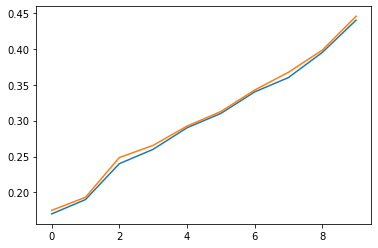

In [83]:
plt.plot(expected_interaction_rates)
plt.plot(estimates)

# References

- Counterfactual Reasoning & Learning Systems